## 04_MNE_preprocessing_ECoG

This notebook is pretty similar to `03_MNE_preprocessing_EEG`, but (you guessed it) with ECoG instead.

### What is different for ECoG?
**Frequency Bands**

EEG records neural responses best in the range of 1-25Hz (recall our PSD plots from last notebook). However, ECoG can record from a much higher range of frequency, up into gamma and high gamma (70-150Hz) bands. This is especially exciting for us speech researchers, because high-gamma band activity has been correlated with a lot of speech stimuli!

However, to extract high gamma response we need to do something called a Hilbert transform. More on that later.

**Artifacts**

ECoG is invasive, that is, it's placed directly on the surface of the brain (or _in_ the brain, in the case of depth electrodes). That means we aren't recording any muscle activity*! So, we don't have to do ICA :)

\* there's a possibility that some depth electrodes are affected by EMG, but we aren't goign to worry about that here

**Referencing**

In EEG, we use a linked mastoid reference because the mastoid electrodes (TP9, TP10) are pretty electrically neutral. That is, underneath them isn't some neurons we're recording from, but instead the bony protuberance of the skull known as the mastoid. Unfortunately, we don't have it so easy with ECoG -- there isn't any one electrode that is guaranteed to be electrically neutral (especially because each patient has their own locations for the electrodes). For ECoG instead we use a common average reference (CAR), which means we are referencing based on the average activity at all electrodes.

In [1]:
import mne
import numpy as np
from tqdm import tqdm # progress bars in python! will use during hilbert transform

In [2]:
# will need to install this if you don't have it already
try:
    from pyfftw.interfaces.numpy_fft import fft, ifft, fftfreq # some Fourier transform related stuff for hilbert transform
except:
    !pip install pyfftw
    from pyfftw.interfaces.numpy_fft import fft, ifft, fftfreq

In [3]:
# remember to change your file path :)
file_path = 'F:/Desktop/example_raw_ecog.fif'
raw = mne.io.read_raw_fif(file_path,preload=True)

Opening raw data file F:/Desktop/example_raw_ecog.fif...
Isotrak not found
    Range : 1331902 ... 1609658 =   2601.371 ...  3143.863 secs
Ready.
Reading 0 ... 277756  =      0.000 ...   542.492 secs...


<ipython-input-3-2d362f436131>:3: RuntimeWarning: This filename (F:/Desktop/example_raw_ecog.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(file_path,preload=True)


In [4]:
# The channel names in ECoG are based on the device and don't follow a montage like EEG does
print('Channel names:', raw.info['ch_names'])
# The sampling rate is also different (512Hz instead of 128Hz)
print('Sampling rate:', raw.info['sfreq'])

Channel names: ['RAST1', 'RAST2', 'RAST3', 'RAST4', 'RAST5', 'RAST6', 'RAST7', 'RAST8', 'RAST9', 'RAST10', 'RAST11', 'RAST12', 'RMST1', 'RMST2', 'RMST3', 'RMST4', 'RMST5', 'RMST6', 'RMST7', 'RMST8', 'RMST9', 'RMST10', 'RMST11', 'RMST12', 'RMST13', 'RMST14', 'RPST1', 'RPST2', 'RPST3', 'RPST4', 'RPST5', 'RPST6', 'RPST7', 'RPST8', 'RPST9', 'RPST10', 'RPST11', 'RPST12', 'RPPST1', 'RPPST2', 'RPPST3', 'RPPST4', 'RPPST5', 'RPPST6', 'RPPST7', 'RPPST8', 'RPPST9', 'RPPST10', 'RPPST11', 'RPPST12', 'RPPST13', 'RPPST14', 'RPPST15', 'RPPST16', 'RAIF1', 'RAIF2', 'RAIF3', 'RAIF4', 'RAIF5', 'RAIF6', 'RAIF7', 'RAIF8', 'RPI1', 'RPI2', 'RPI3', 'RPI4', 'RPI5', 'RPI6', 'RPI7', 'RPI8', 'RPI9', 'RPI10', 'RPI11', 'RPI12', 'RPI13', 'RPI14', 'RPI15', 'RPI16', 'ROF1', 'ROF2', 'ROF3', 'ROF4', 'ROF5', 'ROF6', 'ROF7', 'ROF8', 'ROF9', 'ROF10', 'ROF11', 'ROF12', 'ROF13', 'ROF14', 'ROF15', 'ROF16', 'RAC1', 'RAC2', 'RAC3', 'RAC4', 'RAC5', 'RAC6', 'RAC7', 'RAC8', 'RAC9', 'RAC10', 'RAC11', 'RAC12']
Sampling rate: 512.0


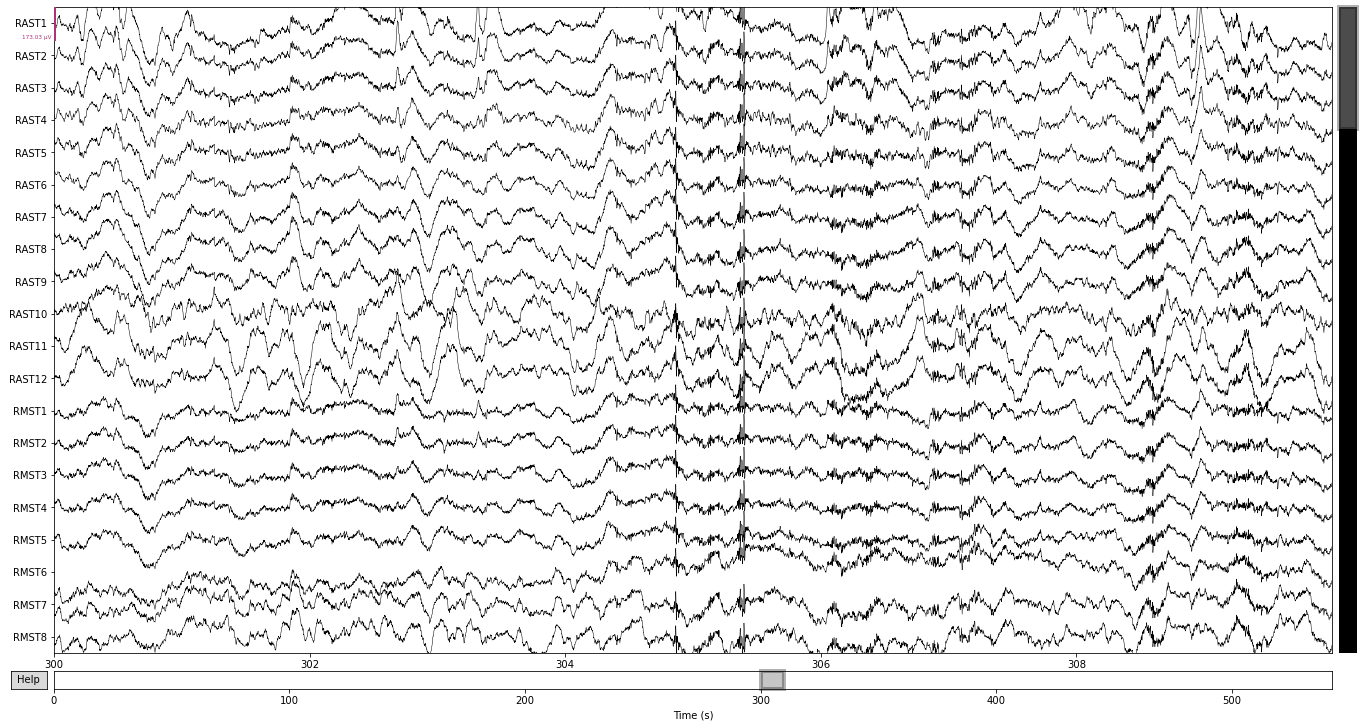

Effective window size : 4.000 (s)


<ipython-input-5-2f956d611f1d>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd();


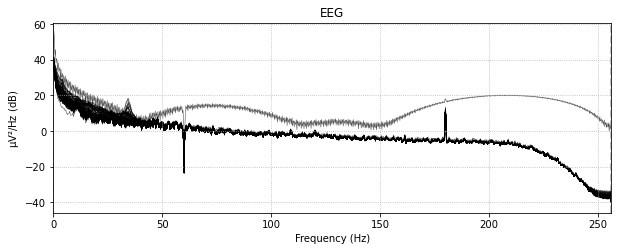

In [5]:
# Let's take a look at our raw data
raw.plot(start=300,scalings='auto');
raw.plot_psd();

## Step 1: Notch filter

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



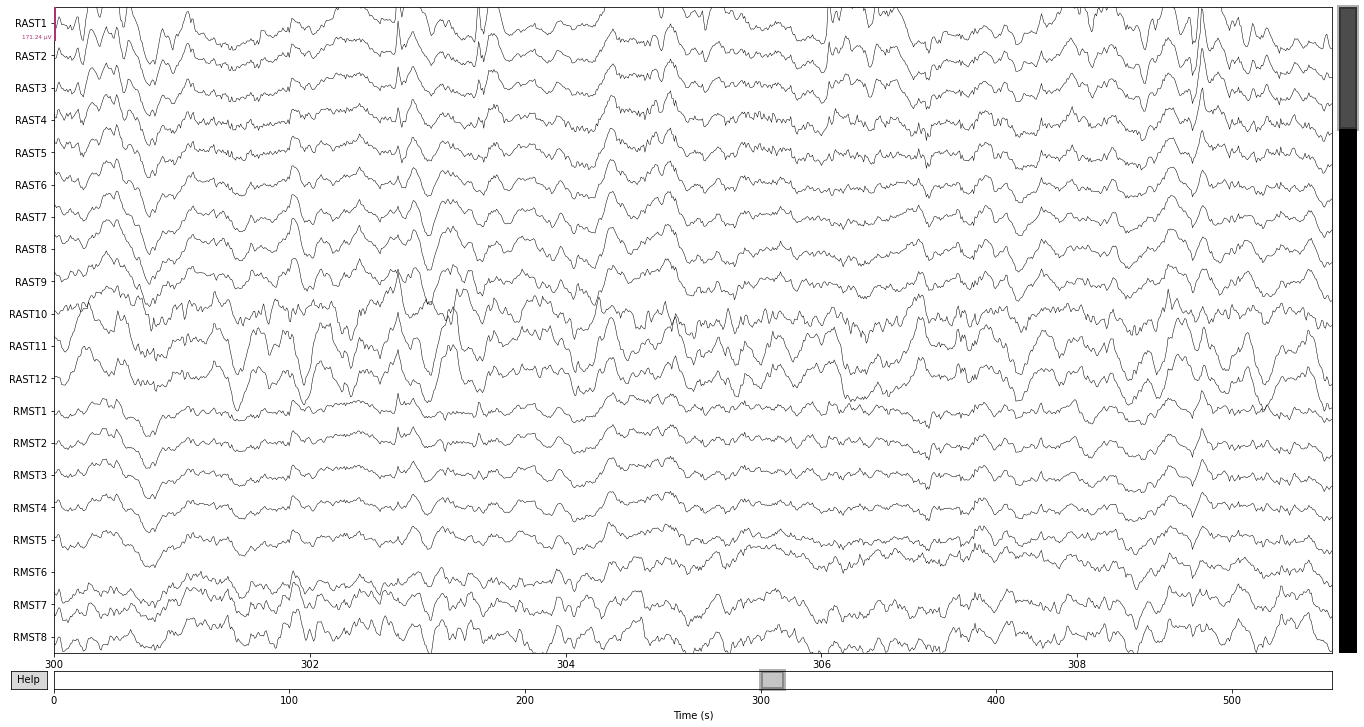

Effective window size : 20.480 (s)


<ipython-input-6-09860f2269fd>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd();


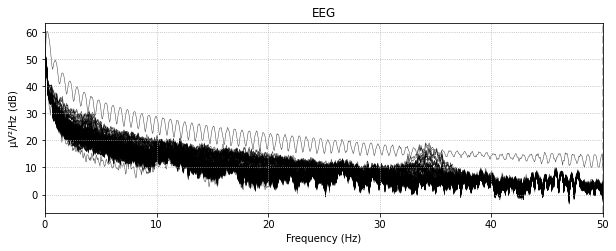

In [6]:
# We notchfilter ECoG too, but at higher frequencies (multiples of 60) because ECoG has a higher response range
raw.notch_filter(np.array((60,120,180)))

# How does this change the raw?
raw.plot(start=300,scalings='auto');
raw.plot_psd();

## Step 2: 🛑✋✋✋✋🛑🛑🛑 s t o p !!! 🛑🛑🛑✋🛑✋🛑✋
Before you apply CAR, you need to manually inspect your ECoG and reject any bad channels. This is so any crappy data isn't added to the reference!

(don't reject bad segments yet, we will do that later)

This is accomplished in the exact same way manual rejection works in EEG, so I'm not going to go over it here. (Hint: use Terminal)

In [7]:
# RMST14 is the only bad channel (i paused while writing this and plotted the raw in Terminal)
# you can mark bad channels like this too
raw.info['bads'] = ['RMST14']

## Step 3: Reference (CAR)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


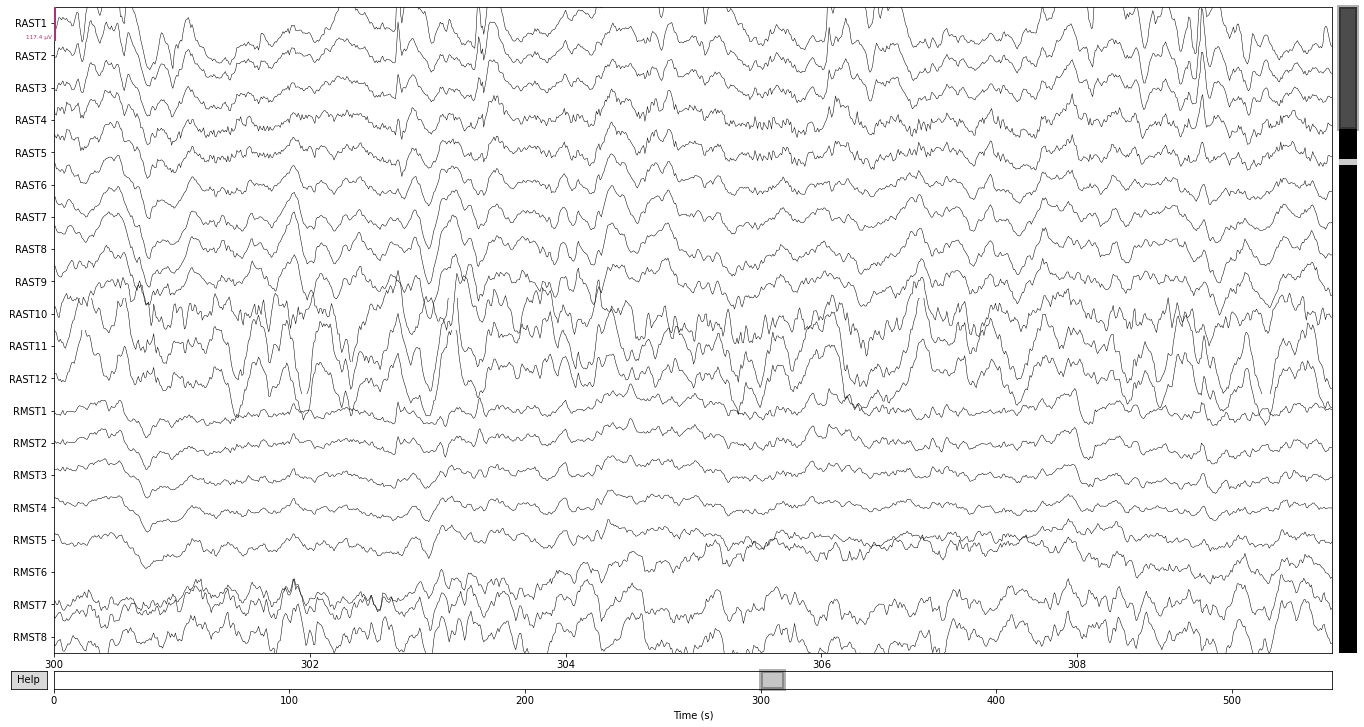

In [8]:
# Apply common average reference
# (bad channels are automatically excluded from raw.set_eeg_reference() btw)
raw.set_eeg_reference(raw.info['ch_names']) # If you have audio in your raw (I removed it here because HIPAA), index it out
raw.plot(start=300,scalings='auto');

## Step 4: Reject bad segments 
This is done identically to EEG (in Terminal). I'll go through this in the video, but in general, you want to reject pretty similarly to EEG, if not rejecting a little bit less than you would with EEG.

## Step 5: Hilbert transform!
A [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform) is a linear transform of the signal that allows us to extract the high gamma response.

In [9]:
# I'm gonna set up some functions to make this easier.

def auto_bands(fq_min=4.0749286538265, fq_max=200., scale=7.):
    """
    Get the frequency bands of interest for the neural signal decomposition.
    Usually these are bands between 4 and 200 Hz, log spaced. 
    These filters were originally chosen by Erik Edwards for his
    thesis work (LH)
    """
    cts = 2 ** (np.arange(np.log2(fq_min) * scale, np.log2(fq_max) * scale) / scale)
    sds = 10 ** (np.log10(.39) + .5 * (np.log10(cts)))
    return cts, sds

def applyHilbertTransform(X, rate, center, sd):
    """
    Apply bandpass filtering with Hilbert transform using a Gaussian kernel
    From https://github.com/HamiltonLabUT/MovieTrailers_TIMIT/blob/master/ECoG/preprocessing/applyHilbertTransform.py
    """
    # frequencies
    T = X.shape[-1]
    freq = fftfreq(T, 1/rate)
    # heaviside kernel
    h = np.zeros(len(freq))
    h[freq > 0] = 2.
    h[0] = 1.
    # bandpass transfer function
    k = np.exp((-(np.abs(freq)-center)**2)/(2*(sd**2)))
    # compute analytical signal
    Xc = ifft(fft(X)*h*k)
    return Xc

In [10]:
# Run the Hilbert transform
nchans = len(raw.info['ch_names']) # if you have stim/audio channels then remove those first
cts, sds = auto_bands() # get some frequency bands of interest
sfreq = raw.info['sfreq']
dat = [] # We will append to this list while doing the hilbert transform
# Loop through frequency bands with a progress bar courtesy of the tqdm package
for i, (ct,sd) in enumerate(tqdm(zip(cts,sds), 'applying Hilbert transform...', total=len(cts))):
    hilbert_dat = applyHilbertTransform(raw.get_data()[:nchans,:], sfreq, ct, sd)
    dat.append(np.abs(hilbert_dat.real.astype('float32') + 1j*hilbert_dat.imag.astype('float32'))) # add hilb data to dat list
hilbert_mat = np.array(np.hstack((dat))).reshape(dat[0].shape[0], -1, dat[0].shape[1])

applying Hilbert transform...: 100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [01:03<00:00,  1.58s/it]


In [11]:
# Extract the high gamma band from the Hilbert-transformed data
hg_low, hg_high = 70, 150 # frequency range
hg_inds = np.bitwise_and(cts>hg_low, cts<hg_high)
hg_signal = hilbert_mat[:,hg_inds,:].mean(1) # Average hilbert across relevant bands
# Rescale
rmax = raw.get_data()[:nchans,:].max()
hg_signal = hg_signal/hg_signal.max()*rmax

In [12]:
# Remove bad time points
hg_signal_nobad = hg_signal.copy()
for i, a in enumerate(raw.annotations.onset):
    onset_samp = np.int((a*sfreq)-raw.first_samp)
    offset_samp = onset_samp + np.int(raw.annotations.duration[i]*sfreq)
    hg_signal_nobad[:,onset_samp] = np.nan # replacing annotated samples with NaN values
    hg_signal_nobad[:,offset_samp] = np.nan
hg_signal=(hg_signal-np.expand_dims(np.nanmean(hg_signal_nobad,axis=1),axis=1))/np.expand_dims(np.nanstd(hg_signal_nobad,axis=1),axis=1)

In [14]:
# Make a new MNE Raw object using the high gamma response
hg_info = mne.create_info(raw.info['ch_names'],sfreq,['ecog']*nchans)
hg_raw = mne.io.RawArray(hg_signal,hg_info)
if raw.annotations: # reject anything we rejected from the original raw from the high gamma raw too
    for annotation in raw.annotations:
        onset = (annotation['onset']-(raw.first_samp/512))
        duration = annotation['duration']
        description = annotation['description']
        hg_raw.annotations.append(onset,duration,description)
hg_raw.resample(sfreq)

Creating RawArray with float64 data, n_channels=106, n_times=54249
    Range : 0 ... 54248 =      0.000 ...   542.480 secs
Ready.


<RawArray | 106 x 54249 (542.5 s), ~44.0 MB, data loaded>

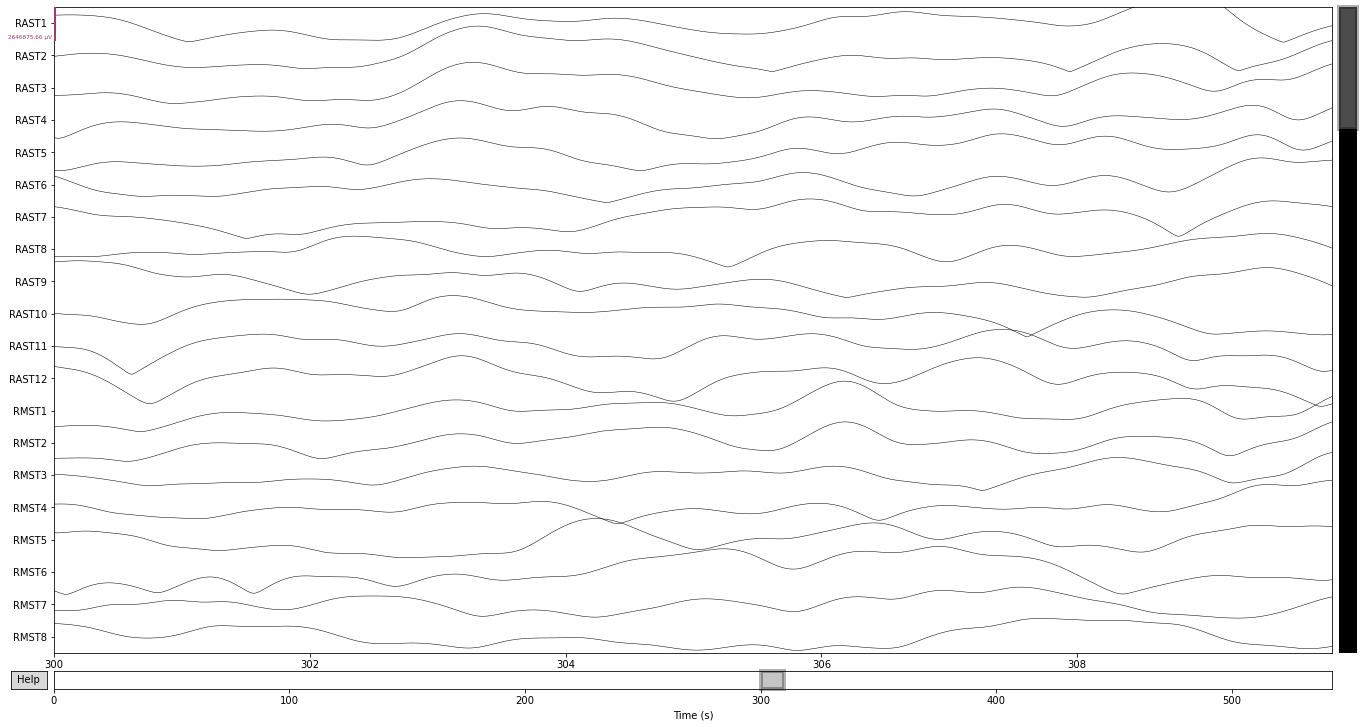

In [15]:
hg_raw.plot(start=300,scalings='auto');